## Setup the environment

In [17]:
import sys
!{sys.executable} -m pip install python-dotenv tqdm firebase-admin asyncio nest_asyncio aiohttp pandas numpy matplotlib pydrive

     |████████████████████████████████| 987 kB 613 kB/s eta 0:00:01
     |████████████████████████████████| 98 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 269 kB 1.8 MB/s eta 0:00:01
  Created wheel for pydrive: filename=PyDrive-1.3.1-py3-none-any.whl size=27435 sha256=0d14a68e0417b3681fddfbbf2221b2af515e3bf60a06e4ce87626fd41896769b
  Stored in directory: /Users/mvshmakovmv/Library/Caches/pip/wheels/57/cc/07/6aac75f5395a224650905accd38c868c2276782a56f1046b7b
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-macosx_10_15_x86_64.whl size=153152 sha256=76ed8591d93d9b8642e69e49c9733aca4e4df451ef9ac12783e55f83302e0299
  Stored in directory: /Users/mvshmakovmv/Library/Caches/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built pydrive PyYAML


## Load .env configuration

Supposing that we have .env in parent folder

In [2]:
%reload_ext dotenv
%dotenv

from dotenv import dotenv_values
ENV = dotenv_values()

## Users DB initialization and queries

In [3]:
import firebase_admin

from firebase_admin import db
from firebase_admin import credentials

In [4]:
class Database():
    def __init__(self):
        # Fetch the service account key JSON file contents
        creds = credentials.Certificate({
            'type': 'service_account',
            "token_uri": "https://accounts.google.com/o/oauth2/token",

            'project_id': ENV['FIREBASE_USERS_PROJECT_ID'],
            'client_email': ENV['FIREBASE_USERS_CLIENT_EMAIL'],
            'private_key': ENV['FIREBASE_USERS_PRIVATE_KEY'].replace('\\n', '\n'),
        })

        # Initialize the app with a service account, granting admin privileges
        firebase_admin.initialize_app(creds, {
            'databaseURL': ENV['FIREBASE_USERS_URL']
        })
        
        # As an admin, the app has access to read and write all data, regradless of Security Rules
        self.users_db = db.reference('users/').get()

    def get_all_chat_ids(self, debug=False):
        if debug:
            return [*list(self.users_db.keys())[1:5], 108431546, 120248031]
        return list(self.users_db.keys())

    def get_users_as_list(self, debug=False):
        if debug:
            return [*list(self.users_db.values())[1:5]]
        return list(self.users_db.values())

In [5]:
database = Database()

## DB analytics

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numbers import Number
from functools import reduce

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [7]:
def users_with_data_stats():
    def remove_without_debug(lst, user):
        if 'debug' in user:
            lst.append(user['debug']['user'])
        return lst

    objects = ('Have', 'Don\'t have')
    y_pos = np.arange(len(objects))

    users = database.get_users_as_list()
    with_debug = reduce(remove_without_debug, users, [])

    x_pos = [
        len(with_debug),
        len(users) - len(with_debug)
    ]

    plt.bar(y_pos[0], x_pos[0], color='blue', align='center')
    plt.bar(y_pos[1], x_pos[1], color='red', align='center')

    plt.ylabel('Number of users')
    plt.xticks(y_pos, objects)
    plt.yticks(x_pos)
    plt.title('Number of users that have debug info')

    plt.show()

    chat_ids_with_debug = list(map(
        lambda user: f"{user['id']} ({user['username']})" if 'username' in user else f"{user['id']} ({user['first_name']})",
        with_debug))

    if len(chat_ids_with_debug) > 0 :
        print(f"Chat_ids with debug: {', '.join(chat_ids_with_debug)}")

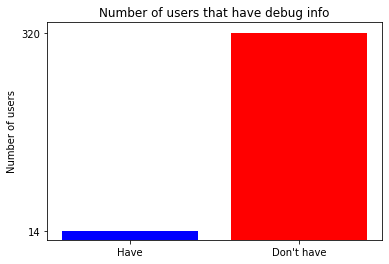

Chat_ids with debug: 80713059 (Barin_Ildar), 94552162 (egorka1397), 108431546 (mvshmakov), 120248031 (le_bourbier), 128855625 (JustDoItTim), 183082518 (DLDLU), 257765200 (xdownshiftx), 259600937 (pvsemk), 313741256 (Alexander), 335299756 (vvmosmvoretskiy), 339755055 (AHTOH4EK), 372861455 (Sde_or), 440708994 (spacedog46471), 1151088630 (Lizzztvv)


In [8]:
users_with_data_stats()

## Sending messages

In [9]:
import json
import aiohttp
import asyncio
from tqdm.notebook import tqdm

In [10]:
# Fix for ipython event loop
import nest_asyncio
nest_asyncio.apply()

In [11]:
class MessageSender():
    headers = {'content-type': 'application/json'}
    stats = {}

    def __init__(self, bot_token=ENV["BOT_TOKEN"]):
        self.url = f'https://api.telegram.org/bot{bot_token}/sendMessage'

    def show_stats(self):
        response = self.stats['response']
        if (response['ok'] != True):
            print(f"{response['description']}. Try again.")
        else:
            chat = response['result']['chat']
            if 'username' in chat:
                print(f"Message \'{response['result']['text']}\' sent to {chat['username']} ({chat['first_name']} {chat['last_name']})")
            else:
                print(f"Message \'{response['result']['text']}\' sent to ({chat['first_name']})")
            print(f"At: {self.stats['date']}, Chat ID: {chat['id']}")

    def send_msg_to_chat(self, chat_id, text):
        loop = asyncio.get_event_loop()

        async def send_msg_to_chat_async():
            async with aiohttp.ClientSession() as session:
                self.stats = await self.send_msg_to_chat_async(session, chat_id, text)

        loop.run_until_complete(send_msg_to_chat_async())

    async def send_msg_to_chat_async(self, session, chat_id, text):
        payload = json.dumps({
            'chat_id': chat_id,
            'text': text
        })

        async with session.post(self.url, data=payload, headers=self.headers) as response:
            text = await response.text()

            return {
                'date': response.headers.get("DATE"),
                'response': json.loads(text),
            }

In [12]:
MAX_PARALLEL = 500

class MultipleMessagesSender(MessageSender):
    stats = []
    
    def stat_count_with_error(self, counter, user):
        if user['response']['ok'] == True:
            return counter
        return counter + 1

    def show_errors_rate(self):
        objects = ('Succeded', 'Errored')
        y_pos = np.arange(len(objects))

        with_error = reduce(self.stat_count_with_error, self.stats, 0)

        x_pos = [
            len(self.stats) - with_error,
            with_error,
        ]

        plt.bar(y_pos[0], x_pos[0], color='blue', align='center')
        plt.bar(y_pos[1], x_pos[1], color='red', align='center')

        plt.ylabel('Number of requests')
        plt.yticks(x_pos)
        plt.xticks(y_pos, objects)
        plt.title('Number of succesful requests and errors')

        plt.show()

    def show_errors(self):
        if reduce(self.stat_count_with_error, self.stats, 0) == 0:
            print('No errors!')
        else:
            def make_errors_map(errs, stat):
                if 'response' not in stat or 'description' not in stat['response']:
                    return errs
                description = stat['response']['description']
                if description in errs:
                    errs[description] += 1
                else:
                    errs[description] = 1
                return errs

            errors = reduce(make_errors_map, self.stats, {})

            x_pos = list(errors.values())
            y_pos = list(errors.keys())
            plt.bar(y_pos, x_pos, color='red', align='center')

            plt.ylabel('Number of errors')
            plt.yticks(x_pos)
            plt.xticks(y_pos, rotation=45)
            plt.title('Errors by description')

            plt.show()
            
    def show_problem_ids(self):
        if reduce(self.stat_count_with_error, self.stats, 0) == 0:
            pass
        else:
            def get_problem_ids(ids, stat):
                if 'description' not in stat['response']:
                    return ids

                chat_id = stat['chat_id']
                if chat_id in ids:
                    return ids
                else:
                    ids.append(chat_id)
                    return ids
            print(f"Problematic chat_ids: {', '.join(map(str, reduce(get_problem_ids, self.stats, [])))}")

    def show_stats(self):
        self.show_errors_rate()
        self.show_errors()
        self.show_problem_ids()

    def send_msg_to_everyone(self, text, parallel=MAX_PARALLEL):
        loop = asyncio.get_event_loop()
        future = asyncio.ensure_future(self.send_msg_to_everyone_async(text, parallel))
        loop.run_until_complete(future)

    async def bound_requests(self, session, semaphore, chat_id, text):
        # Getter function with semaphore.
        async with semaphore:
            return await self.send_msg_to_chat_async(session, chat_id, text)

    async def send_msg_to_everyone_async(self, text, debug=False, parallel=MAX_PARALLEL):
        tasks = []
        chat_ids = database.get_all_chat_ids(debug)
        semaphore = asyncio.Semaphore(parallel)

        # Create client session that will ensure we dont open new connection per each request.
        async with aiohttp.ClientSession() as session:
            for chat_id in chat_ids:
                task = asyncio.ensure_future(
                    self.bound_requests(session, semaphore, chat_id, text))
                tasks.append(task)

            for task in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
                await task

            results = await asyncio.gather(*tasks)
            
            def merge_stat_with_chat_id(accumulator, stat):
                stat[0]['chat_id'] = stat[1]
                accumulator.append(stat[0])
                return accumulator
                
            self.stats = list(reduce(merge_stat_with_chat_id, zip(results, chat_ids), []))

In [21]:
text = 'Привет, это новый бот!!'
chat_id = 108431546

In [22]:
sender = MessageSender()

sender.send_msg_to_chat(chat_id, text)
sender.show_stats()

Message 'Привет, это новый бот!!' sent to mvshmakov (Maxim Shmakov)
At: Fri, 01 May 2020 18:32:23 GMT, Chat ID: 108431546


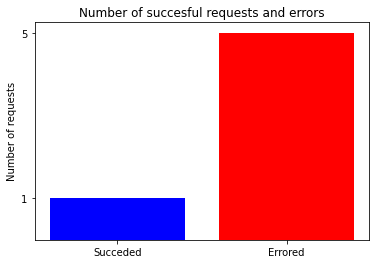

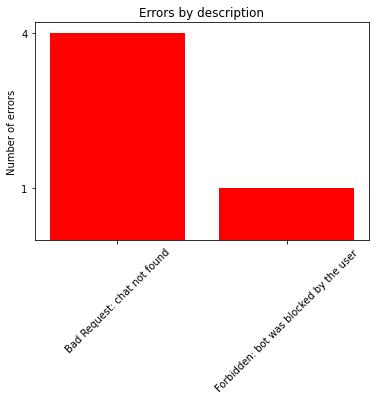

Problematic chat_ids: 2200222, 6157160, 6735995, 7118592, 120248031


In [15]:
multiple_sender = MultipleMessagesSender()

multiple_sender.send_msg_to_everyone(text, True)
multiple_sender.show_stats()

## DB dump in google drive

In [18]:
# !gzip -c hse-military-bot-users-export.json > users-7.04.20-21:56:47.gz
from datetime import datetime

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()
gauth.LocalWebserverAuth()

drive = GoogleDrive(gauth)

InvalidConfigError: Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)

In [35]:
from datetime import datetime

datetime.utcnow().isoformat()

# file = drive.CreateFile({'title': 'Hello.txt'})
# file.SetContentString(json.dumps(database.users_db))
# file.Upload()

'2020-05-01T18:47:23.349603'

In [37]:
# TODO: функция по откату БД
# TODO: очищать все следы жизнедеятельности

In [ ]:
import json
import gzip
 
with gzip.open("input.json.gz", "rb") as f:
    d = json.loads(f.read().decode("utf-8"))